<a href="https://colab.research.google.com/github/inesbsilveira/hummingbirds/blob/main/wildfires_risk_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
!pip install geemap
!pip install geojson

In [35]:
import os
import csv
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, mapping
from shapely.validation import make_valid
import geojson
import ee
import geemap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns

In [36]:
my_project = 'ee-ineshummingbirds'
ee.Authenticate()
ee.Initialize(project= my_project)

In [37]:
# Create a function to process burned area by year
def process_year(n):
    # Calculate the start and end date for each year
    ini = startDate.advance(n, 'year')
    end = ini.advance(1, 'year')

    # Filter the burned area collection for the given year
    result = sst.filterDate(ini, end)
    result = result.max().set('system:time_start', ini)

    # Get the burned area (where BurnDate is not 0) and mask it
    result = ee.Image.pixelArea() \
               .divide(10000) \
               .updateMask(result.neq(0))  # Mask out non-burned areas

    # Sum the area of burned forest for the year
    result = result.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=File,  # Use the converted region geometry
        scale=500,
        maxPixels=1e12,
        tileScale=4
    )

    # Extract the area burned in the forest for that year
    burnedArea = result.get('area')

    # Return the area burned in the forest for that year
    return ee.Feature(None, {'burned_area_ha': burnedArea})

def get_shapefile_centroid(gdf):
    """Ensure CRS is geographic and return the centroid coordinates."""
    if gdf.crs is None or gdf.crs.is_projected:
        gdf = gdf.to_crs(epsg=4326)  # Convert to WGS84 (lat/lon)

    centroid = gdf.unary_union.centroid
    return centroid.y, centroid.x  # (latitude, longitude)

def get_best_crs(latitude, longitude):
    """ Returns the best UTM zone EPSG code based on latitude """
    utm_zone = int((180 + longitude) / 6) + 1
    return f"EPSG:{32600 + utm_zone if latitude >= 0 else 32700 + utm_zone}"

In [38]:

# if the input is a shapefile
country = 'Ivory Coast'
project_area_name = 'Calao' #region/country/project name
input_shp = "cambodia_10km_buffer.shp"
gdf = gpd.read_file(input_shp).to_crs('EPSG:4326')
File = geemap.geopandas_to_ee(gdf)

In [39]:
# Define the date range
start_date = '2000-01-01'
end_date = '2024-12-31'
startDate = ee.Date(start_date)
endDate = ee.Date(end_date)

In [40]:
# calculate number of years to process
nYears = ee.Number(endDate.difference(startDate, 'year')).round().subtract(1)
#print(f'Number of years: {nYears.getInfo()}')

# MODIS Burned Area dataset
sst = ee.ImageCollection("MODIS/061/MCD64A1") \
            .select('BurnDate') \
            .filterDate(startDate, endDate)

# processs burned area per year
byYear = ee.FeatureCollection(
    ee.List.sequence(0, nYears).map(process_year)
)

In [41]:
#features from the Earth Engine FeatureCollection
features = byYear.getInfo()['features']

#'area_ha' values and their corresponding years
data = []
for feature in features:
    year = feature['id']  # The id corresponds to the year index (0-9 in your case)
    area_ha = feature['properties']['burned_area_ha']
    data.append({'year': int(year), 'burned_area_ha': area_ha})

#convert to pandas dataframe
df = pd.DataFrame(data)
# Display the DataFrame
#print(df)


In [42]:
#retrive lat and long to get the adequate CRS for a correct area calculation
latitude, longitude = get_shapefile_centroid(gdf)
#print(f"Central Point: ({latitude}, {longitude})")
best_epsg = get_best_crs(latitude, longitude)
#print(best_epsg)

<ipython-input-37-b14001e8e1ae>:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid


In [43]:
gdf_crs = gdf.to_crs(best_epsg)
total_area_ha = (gdf_crs['geometry'].area/10000).sum()
print(f"Total area in hectares: {total_area_ha}")

Total area in hectares: 164141.77709618467


In [44]:
#add new column to the df with the percentage of burned area per year
df['burned_area_percentage'] = (df['burned_area_ha'] / total_area_ha) * 100
# Display the updated DataFrame
print(df)

    year  burned_area_ha  burned_area_percentage
0      0      771.985947                0.470317
1      1    22527.659207               13.724513
2      2    32303.577558               19.680290
3      3    55769.267117               33.976278
4      4    45394.784516               27.655838
5      5    50810.761170               30.955411
6      6    45912.354537               27.971157
7      7    62732.277895               38.218349
8      8    55291.443056               33.685174
9      9    66704.124239               40.638115
10    10    50756.461653               30.922330
11    11    47576.621079               28.985077
12    12    55404.591508               33.754107
13    13    42191.156464               25.704094
14    14    50991.353786               31.065433
15    15    37928.171263               23.106958
16    16    40310.413712               24.558290
17    17    40984.549520               24.968993
18    18    52747.521009               32.135342
19    19    51600.43

In [45]:
# Calculate mean and standard deviation for area burned in hectares
mean_area = df['burned_area_ha'].mean()
std_area = df['burned_area_ha'].std()
mean_area_percentage = df['burned_area_percentage'].mean()
std_area_percentage = df['burned_area_percentage'].std()
print(f"Mean of burned area (ha): {mean_area}")
print(f"Standard deviation of burned area: {std_area}")
print(f"Mean of burned area (%): {mean_area_percentage}")
print(f"Standard deviation of burned area (%): {std_area_percentage}")

Mean of burned area (ha): 46185.36263480737
Standard deviation of burned area: 14176.232590804018
Mean of burned area (%): 28.13748178670164
Standard deviation of burned area (%): 8.636577988611002


In [50]:
#TIME SINCE LAST FIRE
# Sort data by year (ensure it's sorted)
df = df.sort_values('year', ascending=True)
big_fire_threshold_perc = mean_area_percentage
low_fire_threshold_perc = mean_area_percentage - (std_area_percentage)

# Find the most recent year with a big fire
years_big_fires = df[df['burned_area_percentage'] >= big_fire_threshold_perc]
years_moderate_fires = df[(df['burned_area_percentage'] >= low_fire_threshold_perc) & (df['burned_area_percentage'] < big_fire_threshold_perc)]
years_low_fires = df[df['burned_area_percentage'] < low_fire_threshold_perc]
num_years_moderate_fires = len(years_moderate_fires)
num_years_low_fires = len(years_low_fires)
num_years_big_fires = len(years_big_fires)

if not years_big_fires.empty:
    last_big_fire_year = years_big_fires['year'].max()
else:
    last_big_fire_year = None  # No big fire found

# current year is the most recent year in the dataset (ascending order)
current_year = df['year'].max()

# calculate time since last (big)fire
if last_big_fire_year:
    years_since_last_big_fire = current_year - last_big_fire_year
else:
    years_since_last_big_fire = float('inf')  # If no fire, treat as very long ago



print(f"Total number of big fires: {num_years_big_fires}")
print(f"Total number of moderate fires: {num_years_moderate_fires}")
print(f"Total number of low fires: {num_years_low_fires}")
print(f"Year of last big fire: 20{last_big_fire_year}")
print(f"Nr of years since last big fire: {years_since_last_big_fire}")


Total number of big fires: 15
Total number of moderate fires: 7
Total number of low fires: 3
Year of last big fire: 2024
Nr of years since last big fire: 0


In [51]:
# Filter moderate and low fires that happened after the last big fire
# Filter fires that happened after the last big fire
if last_big_fire_year:
    fires_after_last_big_fire = df[df['year'] > last_big_fire_year]

    moderate_fires_after = fires_after_last_big_fire[
        (fires_after_last_big_fire['burned_area_percentage'] >= low_fire_threshold_perc) &
        (fires_after_last_big_fire['burned_area_percentage'] < big_fire_threshold_perc)
    ]

    low_fires_after = fires_after_last_big_fire[
        fires_after_last_big_fire['burned_area_percentage'] < low_fire_threshold_perc
    ]

    total_fires_after_last_big_fire = len(fires_after_last_big_fire)
else:
    moderate_fires_after = df[(df['burned_area_percentage'] >= low_fire_threshold_perc) &
                              (df['burned_area_percentage'] < big_fire_threshold_perc)]
    low_fires_after = df[df['burned_area_percentage'] < low_fire_threshold_perc]
    total_fires_after_last_big_fire = len(df)  # Count all fires if no big fire exists


# Count fires
num_moderate_fires_after = len(moderate_fires_after)
num_low_fires_after = len(low_fires_after)

print(f"Total number of fires after last big fire: {total_fires_after_last_big_fire}")
print(f"Total number of moderate fires after last big fire: {num_moderate_fires_after}")
print(f"Total number of low fires after last big fire: {num_low_fires_after}")

Total number of fires after last big fire: 0
Total number of moderate fires after last big fire: 0
Total number of low fires after last big fire: 0


In [52]:
# Calculate nYears
nYears = int(current_year - df['year'].min())

# Classify fire risk
if num_years_big_fires >= nYears / 2:
    fire_risk = "High"
elif num_years_big_fires <= nYears / 8:
    fire_risk = "Low"
else:
    fire_risk = "Medium"

print(f"Fire Risk Classification: {fire_risk}")


Fire Risk Classification: High


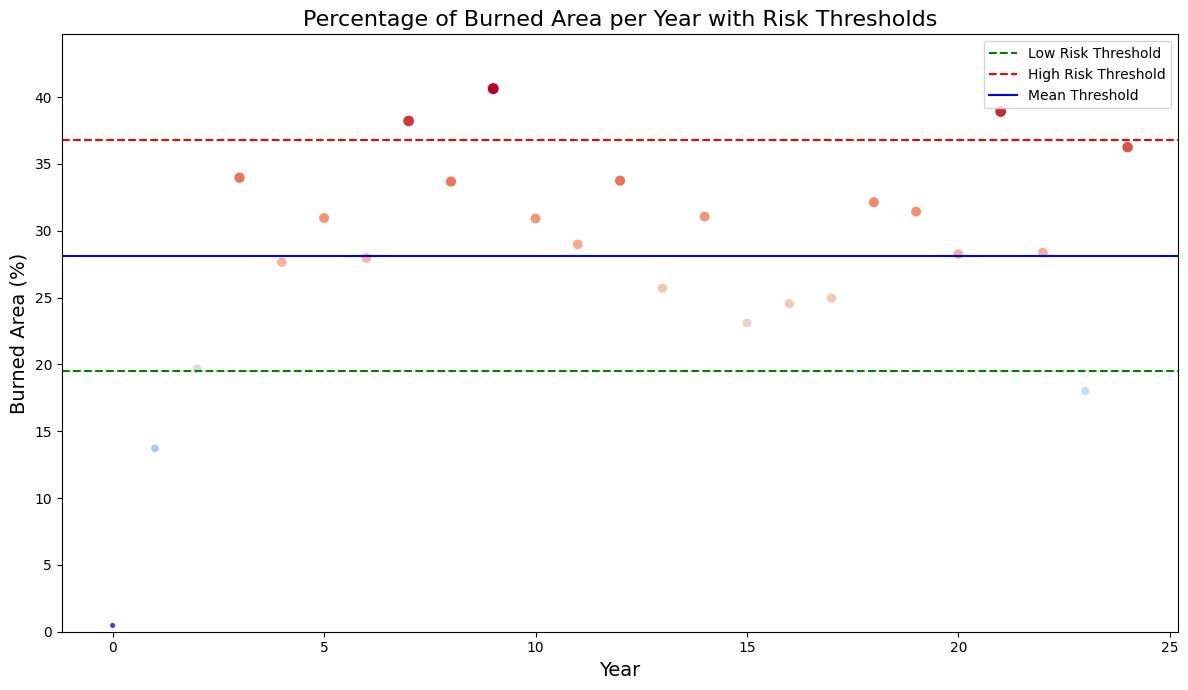

In [49]:
# Calculate thresholds for risk levels
mean_area = df['burned_area_percentage'].mean()
std_area = df['burned_area_percentage'].std()

low_risk_threshold = mean_area - (std_area)
high_risk_threshold = mean_area + (std_area)
mean_threshold = mean_area

# Apply the size category function to the 'burned_area_ha' column
df['point_size'] = df['burned_area_percentage']

# Create the scatter plot
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, x='year', y='burned_area_percentage', size='point_size',
                hue='burned_area_percentage', palette='coolwarm', legend=False)

# Add horizontal lines for risk thresholds
plt.axhline(y=low_risk_threshold, color='green', linestyle='--', label='Low Risk Threshold')
plt.axhline(y=high_risk_threshold, color='red', linestyle='--', label='High Risk Threshold')
plt.axhline(y=mean_threshold, color='blue', linestyle='-', label='Mean Threshold')

# Set labels and title
plt.title('Percentage of Burned Area per Year with Risk Thresholds', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Burned Area (%)', fontsize=14)
#plt.yscale('log')
plt.ylim(0, df['burned_area_percentage'].max()*1.1)

# Show legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
